# Homework 4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing
import networkx as nx
from networkx.algorithms import bipartite

import seaborn as sns

%matplotlib inline

In [2]:
lalonde = pd.read_csv(r'lalonde.csv')
lalonde.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [3]:
lalonde.isna().values.any()

False

In [4]:
lalonde.set_index("id", inplace=True)
lalonde.index.duplicated().any()

False

In [5]:
lalonde.dtypes

treat         int64
age           int64
educ          int64
black         int64
hispan        int64
married       int64
nodegree      int64
re74        float64
re75        float64
re78        float64
dtype: object

Let's merge all the race information in one column and define it in the following way:
- 0 for black
- 1 for hispan
- 2 for white

In [6]:
lalonde["race"] = 2 - 2*lalonde.black - lalonde.hispan
lalonde = lalonde.drop(["black", "hispan"], axis=1)

In [7]:
lalonde.describe()

,treat,age,educ,married,nodegree,re74,re75,re78,race
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.415309,0.630293,4557.546569,2184.938207,6792.834483,1.091205
std,0.459198,9.881187,2.628325,0.493177,0.483119,6477.964479,3295.679043,7470.730792,0.935865
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,238.283425,0.000000
50%,0.000000,25.000000,11.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500,1.000000
75%,1.000000,32.000000,12.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500,2.000000
max,1.000000,55.000000,18.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000,2.000000


All values are in the correct range

In [8]:
lalonde_treat = lalonde[lalonde.treat == 1]
lalonde_notreat = lalonde[lalonde.treat == 0]

In [9]:
lalonde_treat.re78.describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [10]:
lalonde_notreat.re78.describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

The mean outcome for the non-treated group is slightly larger but the max salary for the other group is way larger !

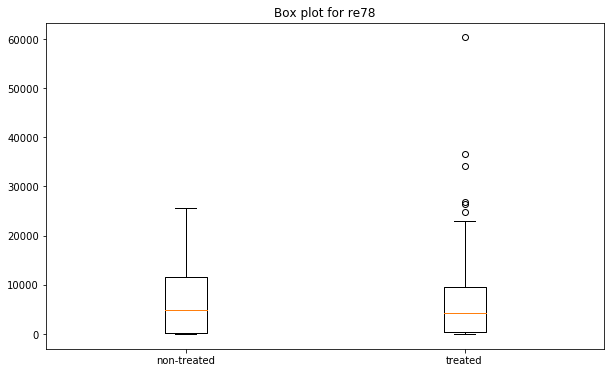

In [11]:
plt.figure(figsize=(10,6))
plt.title("Box plot for re78")
plt.boxplot((lalonde_notreat.re78.values, lalonde_treat.re78.values), labels=("non-treated", "treated"))

plt.show()

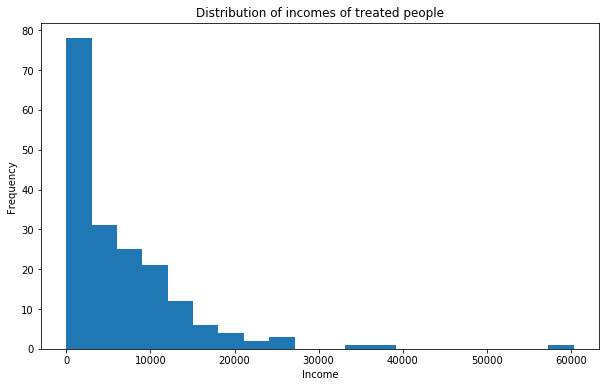

In [12]:
plt.figure(figsize=(10,6))
plt.title("Distribution of incomes of treated people")
plt.xlabel("Income")
lalonde_treat.re78.plot.hist(bins=20)
plt.show()

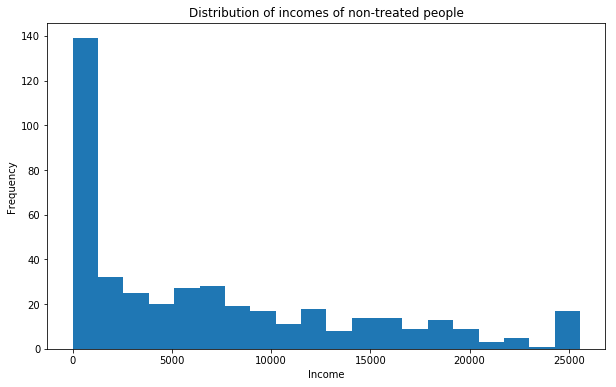

In [13]:
plt.figure(figsize=(10,6))
plt.title("Distribution of incomes of non-treated people")
plt.xlabel("Income")
lalonde_notreat.re78.plot.hist(bins=20)
plt.show()

In [14]:
def compare_hist(feature, title, no_treat_df=lalonde_notreat, treat_df=lalonde_treat, bins=None, fit=True, normed=True):
    plt.figure(figsize=(11,8))
    plt.title("Distribution of " + title)
    
    sns.distplot(no_treat_df[feature], label="no treat", bins=bins, kde=fit, norm_hist=normed)
    sns.distplot(treat_df[feature], label="treat", bins=bins, kde=fit, norm_hist=normed)

    plt.ylabel("Density" if normed else "Count")

    plt.legend(loc="upper right")
    plt.show()

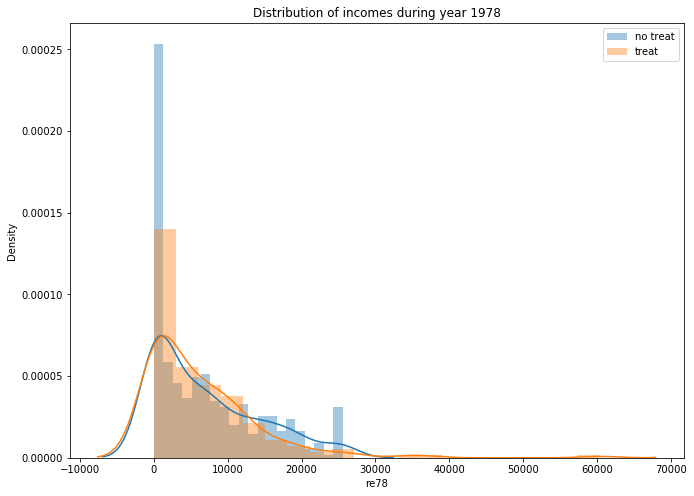

In [15]:
compare_hist("re78", "incomes during year 1978", bins=20)

The income of the non-treated people seems generally higher !

A naive researcher might conclude that the training has a negative influence on the salary of the people. Indeed, people who didn't get the training seem to have a higher salary in average (both the mean and the median are higher for the no-training group

## 2

In [16]:
lalonde_treat.describe()

,treat,age,educ,married,nodegree,re74,re75,re78,race
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.189189,0.708108,2095.573689,1532.055314,6349.143530,0.254054
std,0.0,7.155019,2.010650,0.392722,0.455867,4886.620353,3219.250870,7867.402218,0.621444
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,485.229800,0.000000
50%,1.0,25.000000,11.000000,0.000000,1.000000,0.000000,0.000000,4232.309000,0.000000
75%,1.0,29.000000,12.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000,0.000000
max,1.0,48.000000,16.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000,2.000000


Impressive, the median for re74 and re75 are 0 ! This group certainly contains younger people without a professional experience yet

In [17]:
lalonde_notreat.describe()

,treat,age,educ,married,nodegree,re74,re75,re78,race
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.512821,0.596737,5619.236506,2466.484443,6984.169742,1.452214
std,0.0,10.786653,2.855238,0.500419,0.491126,6788.750796,3291.996183,7294.161791,0.809220
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,220.181300,1.000000
50%,0.0,25.000000,11.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000,2.000000
75%,0.0,35.000000,12.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000,2.000000
max,0.0,55.000000,18.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000,2.000000


We already see, amongst other information, that the mean age in the "no-treat" group is higher. This could imply that they have a greater professional experience. We also see the pre-treatment incomes which are much higher for the "no-treat" group. Let's visualize all that

### RE74

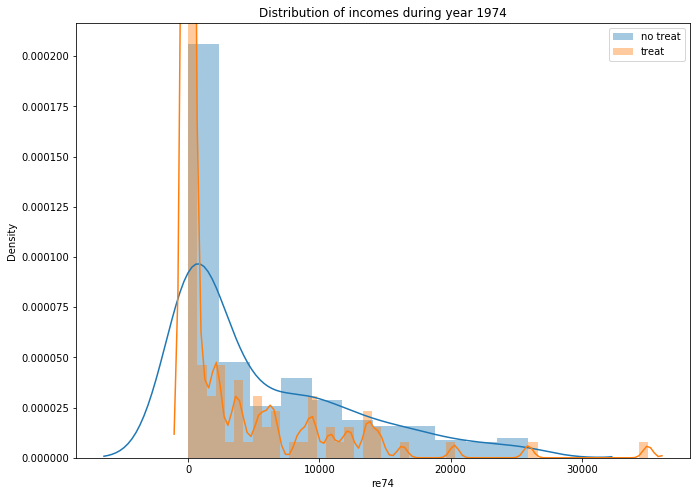

In [18]:
compare_hist("re74", "incomes during year 1974")

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


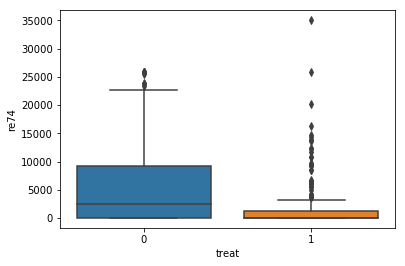

In [19]:
sns.boxplot(x="treat", y="re74", data=lalonde)

### RE75

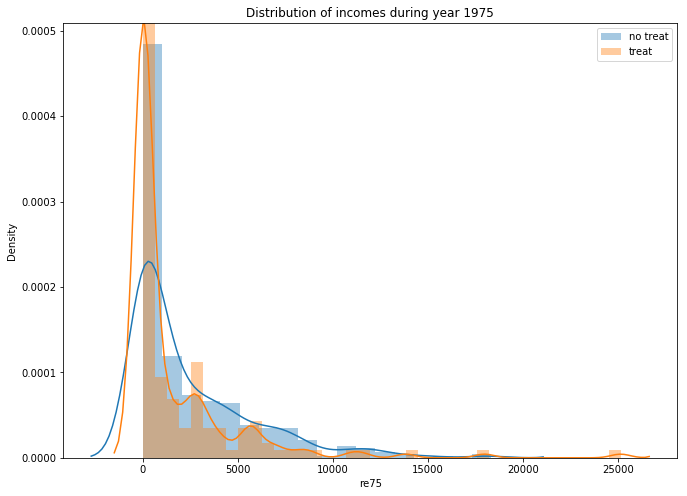

In [20]:
compare_hist("re75", "incomes during year 1975")

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


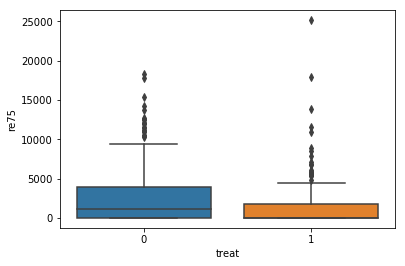

In [21]:
sns.boxplot(x="treat", y="re75", data=lalonde)

We can see that people in the "no-treat" group already earned more than those of the other group pre-treatment. Then it's no surprise they earn more not long after the treatment.

### Age

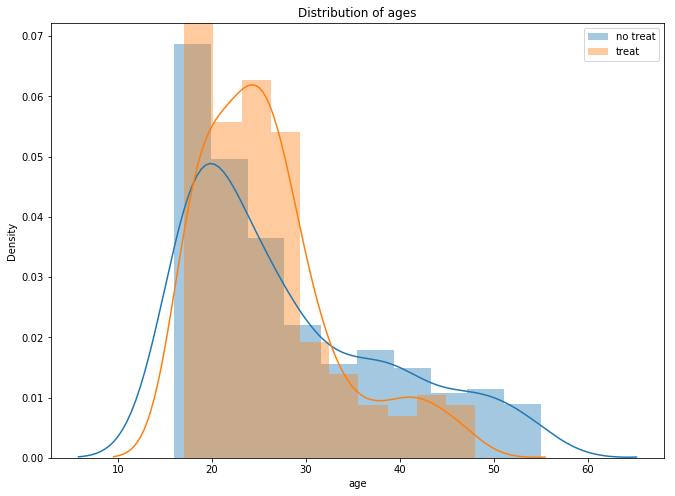

In [22]:
compare_hist("age", "ages")

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


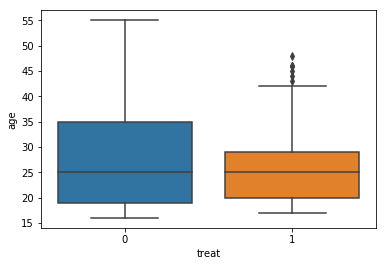

In [23]:
sns.boxplot(x="treat", y="age", data=lalonde)

### Duration of education

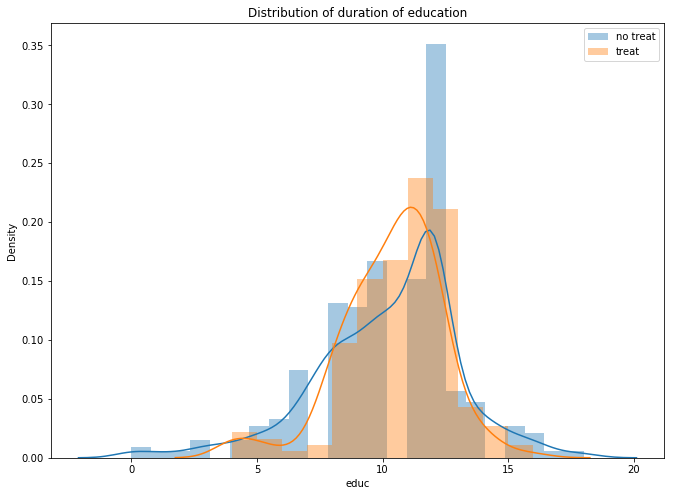

In [24]:
compare_hist("educ", "duration of education")

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


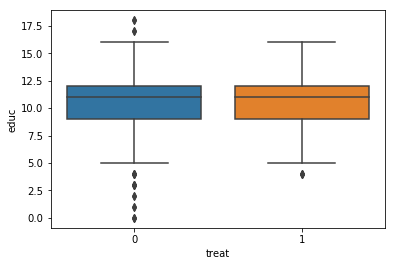

In [25]:
sns.boxplot(x="treat", y="educ", data=lalonde)

People without a training already 

### Race

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


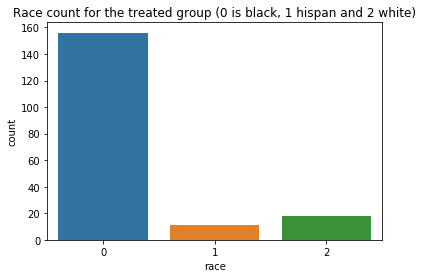

In [26]:
plt.title("Race count for the treated group (0 is black, 1 hispan and 2 white)")
sns.countplot(x="race", data=lalonde_treat)

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


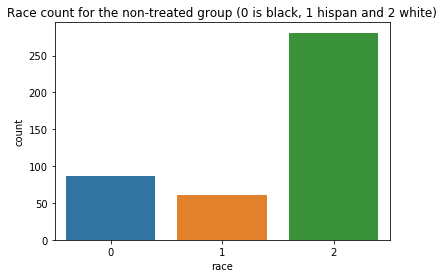

In [27]:
plt.title("Race count for the non-treated group (0 is black, 1 hispan and 2 white)")
sns.countplot(x="race", data=lalonde_notreat)

### Degree

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


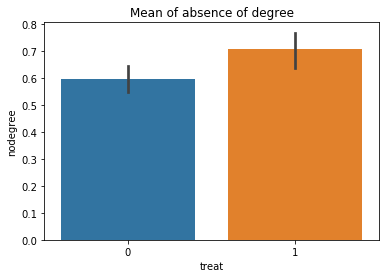

In [28]:
plt.title("Mean of absence of degree")
sns.barplot(x="treat", y="nodegree", data=lalonde)

Now we see that the value has nothing special to do with treat or no treat. Somehow we see that the selection was far from uniform at random. In the treat group there are more people with no degree than with degree. The "black" variable is interesting also. We intuitively make associate the fact that there are a lot more black people to more difficult social conditions. We can also note that there is a three years difference in mean age between the two groups so, in a sense, we guess that people in the no treat group have more experience on average and this should imply the higher mean salary in the no treat group. We can also say that the age parameter has a lot of impact on the nodegree and the married parameters. Somehow, being 3 years older implies a higher probability of being married and a higher probability of having a degree.

Now we want to measure the propensity scores using logistic regression in order to be able to improve our analysis.

## 3

In [29]:
logistic = linear_model.LogisticRegression()
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

# We won't include re78 since this is the salary after the subject is treated
features = ["age", "educ", "race", "married", "nodegree", "re74", "re75"]
X = scaler.fit_transform(lalonde[features])
#X = (lalonde[features] - lalonde[features].mean(axis=0))/lalonde[features].std(axis=0)
y = lalonde.treat

logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Now let's take a look at the score:

In [30]:
logistic.score(X, y)

0.82410423452768733

In [31]:
logistic.predict_proba(X)

array([[ 0.45051862,  0.54948138],
       [ 0.67548293,  0.32451707],
       [ 0.34323669,  0.65676331],
       ..., 
       [ 0.87957928,  0.12042072],
       [ 0.55728502,  0.44271498],
       [ 0.90537355,  0.09462645]])

Not bad for a start. We are really far from 0.5 which could mean that we are really far from a randomized experiment. Bad this score is not really informative, what we want here is the propensity score measure.

In [32]:
propensity = [b for [a,b] in logistic.predict_proba(X)]

Now we have our propensity scores for all "nodes"

In [33]:
propensity[:5]

[0.5494813811626329,
 0.32451706861664004,
 0.65676330752689249,
 0.71393093431280974,
 0.6826138658122155]

## 4

What we want now is to do matching : we would like to match each subject of the *treat* group with another one from the *non-treat* group having a close propensity score

Now we want to separate the dataset into the treat and no treat groups:

In [34]:
data_propensity = lalonde.copy()
data_propensity["propensity"] = propensity

data_treat_propensity = data_propensity[data_propensity.treat == 1]
data_no_treat_propensity = data_propensity[data_propensity.treat == 0]

Now let's go and create a bipartite graph. So our first strategy (we will find another one if this one doesn't work) is that the weight of the edge between the two nodes is the absolute difference in propensity scores between them. And then we will use networkx to find a min-weight matching

In [35]:
G = nx.DiGraph()

G.add_nodes_from(data_treat_propensity.index.values, bipartite=0)
G.add_nodes_from(data_no_treat_propensity.index.values, bipartite=1)

for i, row_i in data_treat_propensity.iterrows():
    for j, row_j in data_no_treat_propensity.iterrows():
        # Since the method we use is based on max matching we use negative value to get min matching
        G.add_edge(i, j, weight = -abs(row_i["propensity"] - row_j["propensity"]))

Now let us compute the matching (it takes around a minute):

In [36]:
matching_propensity_max_card = nx.max_weight_matching(G, maxcardinality=True)
matching_propensity_max_card = {k:v for (k,v) in matching_propensity_max_card.items() if "NSW" in k}
len(matching_propensity_max_card)

185

We can also compute the min weight matching without max cardinality:

In [37]:
matching_propensity = nx.max_weight_matching(G)

# the matchings are duplicated (1 -> 2 and 2 -> 1), we will only keep the first pair
matching_propensity = {k:v for (k,v) in matching_propensity.items() if "NSW" in k}
len(matching_propensity)

10

But the problem, as we can see, is that we end up with too few datapoints in the end:

In [38]:
def observe_matching(matching, verbose):
    sum_differences = 0
    for (a, b) in matching.items():
        propensity_score_a = data_propensity.loc[a]["propensity"]
        propensity_score_b = data_propensity.loc[b]["propensity"]
        diff = abs(propensity_score_a - propensity_score_b)
        if verbose:
            print("Difference between {} and {} is {}".format(a, b, diff))
        sum_differences += diff
    print("Mean difference in prop score is {}".format(sum_differences / len(matching)))
    
observe_matching(matching_propensity, False)

Mean difference in prop score is 0.0


Here we see the problem with using min matching without max cardinality. The algorithm will compute the "real" min matching and it will only match the points with the same propensity scores for that. We will continue with the matchings we obtained from max cardinality matchings:

In [39]:
observe_matching(matching_propensity_max_card, False)

Mean difference in prop score is 0.18378618648102227


This matching takes into account all datapoints from the treat (the smallest) group. So it has 185 matchings. In general those matchings are pretty good, very similar points are matched with each other. But if we inspect the values we see that there are some "outliers" matchings since all points have to be matched.

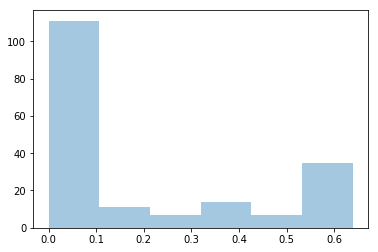

In [40]:
propensity_differences_matchings = list(map(lambda matching: (matching[0], abs(data_propensity.loc[matching[0]]["propensity"] - data_propensity.loc[matching[1]]["propensity"])), 
                                                   matching_propensity_max_card.items()))
propensity_differences_matchings = [prop for (index, prop) in propensity_differences_matchings]
sns.distplot(propensity_differences_matchings, kde=False)

Looking at this histogram we see that there are some bothering matchings where the differences in propensity scores are more than 0.5. A third alternative may be to apply a threshold after the matching to get rid of those values but let's already see how far we can go with our 185-matchings set

Now let's look at the re78 values for both groups but we will take into account only the matched datapoints

In [41]:
group_treat = [a for (a, b) in matching_propensity_max_card.items()]
group_no_treat = [b for (a, b) in matching_propensity_max_card.items()]

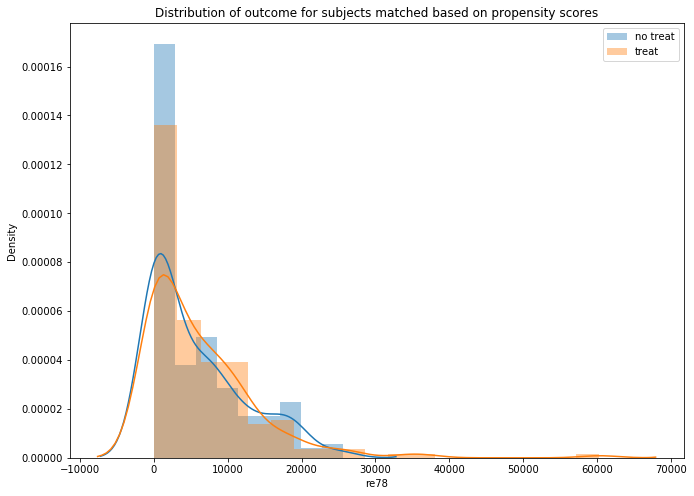

In [42]:
compare_hist("re78","outcome for subjects matched based on propensity scores", no_treat_df=lalonde.loc[group_no_treat], treat_df=lalonde.loc[group_treat])

So this is our distribution. Maybe we can argue we see things in a better way on this histogram. The number of samples is exactly the same for both groups (the number of samples in the treat group) and the two groups were obtained using the min matching method on the bipartite graph. Here we clearly see that the "extreme" outliers belong to the treat group. But however, there are not so many of them. We can also see that the first bin (the least salary) contains more people from the non treated than the treated group (however, if we look at the re78 column in out dataset we see that there are a lot of 0 values so either the dataset has errors or those people are simply unemployed). So the only thing we might try to guess from this is that the treat works well on a few people: the blue outliers. (but maybe those people anyway had more determination and this determination is what caused them to take the treat so the variable is something that we do not have in our dataset: the determination)

Now let's tweak things to see if we can get better insights. The first thing we want to try is to simply remove the matchings where the difference is too big. We will end up with much less datapoints but we might get something out of it:

In [43]:
def filter_matching(matching, threshold=0.4):
    def difference_matching(x, y):
        return abs(data_propensity.loc[x]["propensity"] - data_propensity.loc[y]["propensity"])

    matching_propensity_max_card_pairs = map(lambda x : (x[0], x[1], difference_matching(x[0], x[1])), matching.items())
    matching_propensity_max_card_pairs = filter(lambda x : x[2] <= threshold, matching_propensity_max_card_pairs)
    return list(matching_propensity_max_card_pairs)

def plot_matching_hist(matching, threshold=0.4):
    matchings = filter_matching(matching, threshold)
    group_treat = [a for (a, b, prop) in matchings]
    group_no_treat = [b for (a, b, prop) in matchings]
    compare_hist("re78","outcome for subjects matched based on propensity scores", no_treat_df=lalonde.loc[group_no_treat], treat_df=lalonde.loc[group_treat])

Let's see what we get with the threshold at 0.4:

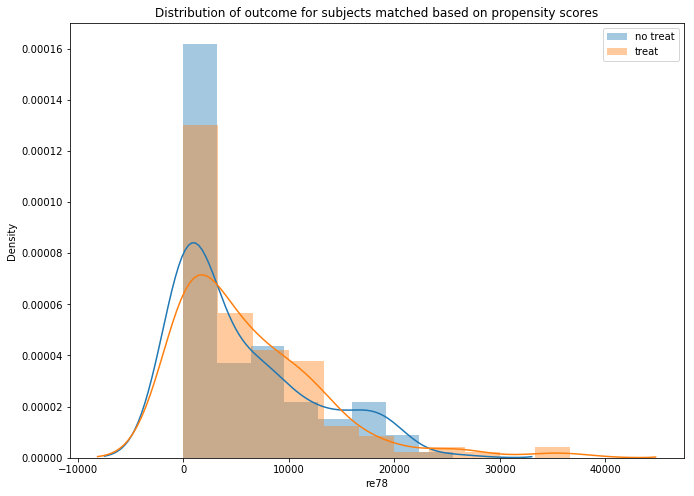

In [44]:
plot_matching_hist(matching_propensity_max_card, 0.4)

And at 0.2:

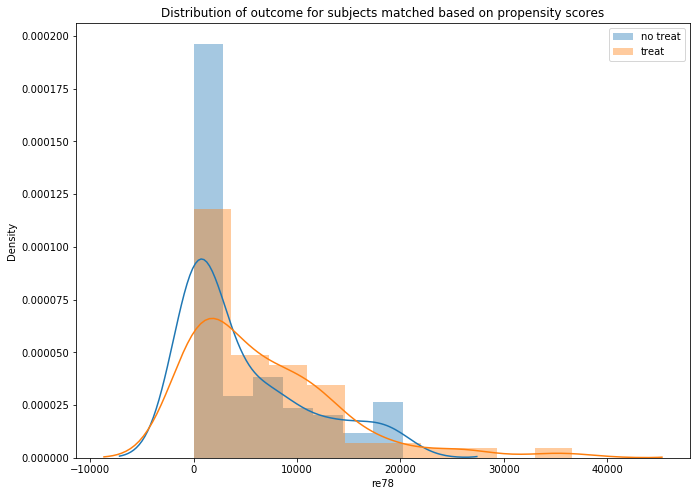

In [45]:
plot_matching_hist(matching_propensity_max_card, 0.2)

At 0.1 (very similar propensity scores):

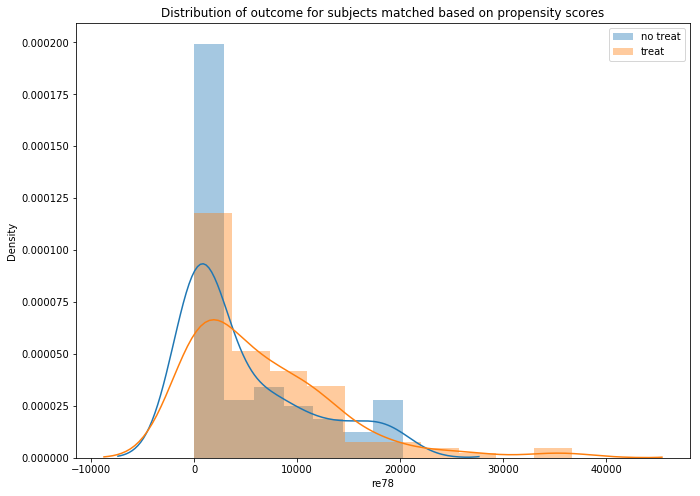

In [46]:
plot_matching_hist(matching_propensity_max_card, 0.1)

At 0.05 (very very similar propensity scores)

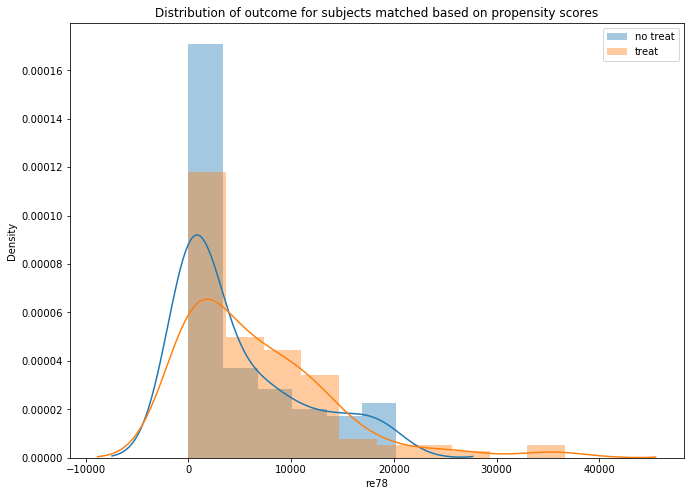

In [47]:
plot_matching_hist(matching_propensity_max_card, 0.05)

At 0 (Exactly the same propensity scores) :

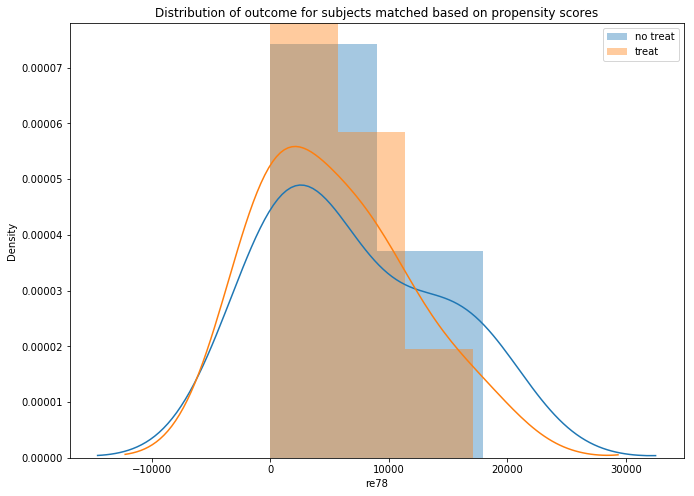

In [48]:
plot_matching_hist(matching_propensity_max_card, 0)

The general thing we always see no matter the threshold is that the treat group always has those outliers who have really big salaries (except in the threshold 0 case where they do not appear).

## 5

The general trend is somehow appearing: people in the no-treat group have a higher salary because they have more experience, are older and probably have better social conditions but there are a few outliers from the treat group. Let's try to redo our visualizations on the new data in order to see if there are some problematic variables.

In [143]:
group_treat = [a for (a, b) in matching_propensity_max_card.items()]
group_no_treat = [b for (a, b) in matching_propensity_max_card.items()]
lalonde_matched_treat = lalonde.loc[group_treat]
lalonde_matched_no_treat = lalonde.loc[group_no_treat]

lalonde_matched = pd.concat([lalonde_matched_treat, lalonde_matched_no_treat])

def compare_distributions(variable, action="matching", data1=lalonde, data2=lalonde_matched):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    plt.suptitle("{} distributions before and after {}".format(variable, action))
    axes[0].set_title("{} distribution before {}".format(variable, action))
    axes[1].set_title("{} distribution after {}".format(variable, action))
    if variable in ["educ", "age", "re74", "re75", "re78"]:
        sns.boxplot(x="treat", y=variable, data=data1, ax=axes[0])
        sns.boxplot(x="treat", y=variable, data=data2, ax=axes[1])
    elif variable in ["nodegree", "married"]:
        sns.barplot(x="treat", y=variable, data=data1, ax=axes[0])
        sns.barplot(x="treat", y=variable, data=data2, ax=axes[1])
    elif variable in ["race"]:
        sns.countplot(x="race", hue="treat", data=data1, ax=axes[0])
        sns.countplot(x="race", hue="treat", data=data2, ax=axes[1])
    plt.show()

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


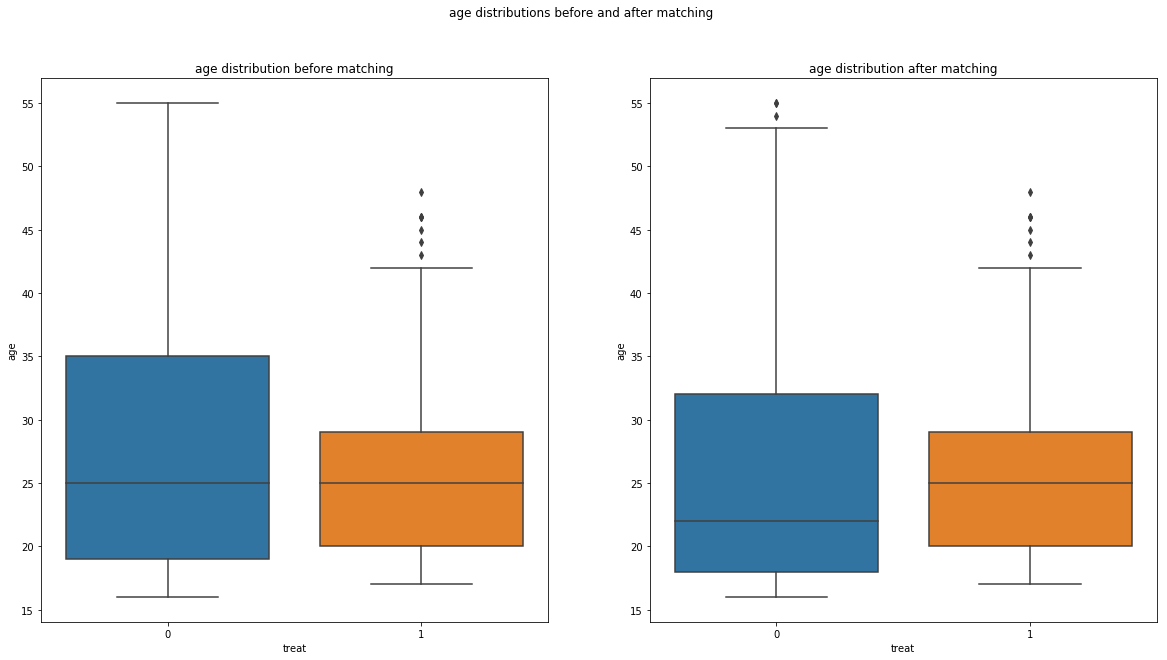

In [144]:
compare_distributions("age")

The age distribution seems a lot better, especially for the treat = 1 case. But we see that the two distributions are still a lot different !

Educ distributions after matching:

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


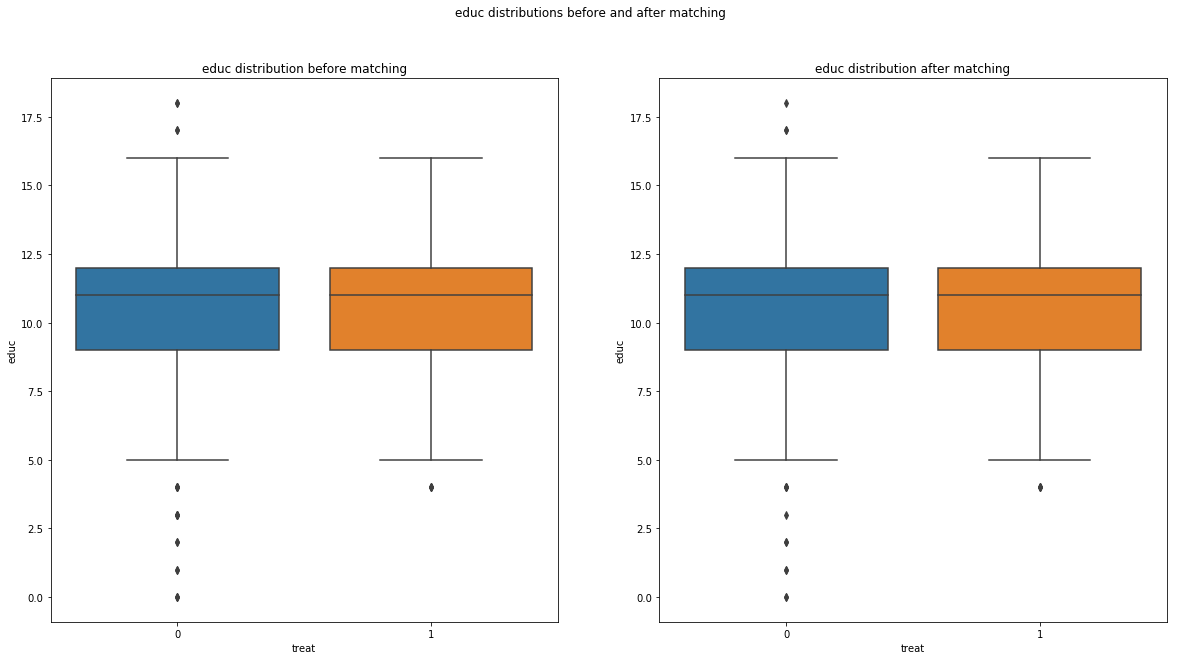

In [145]:
compare_distributions("educ")

Nothing to say about this. The educ distribution was already very good before the matching.

nodegree distributions after matching:

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


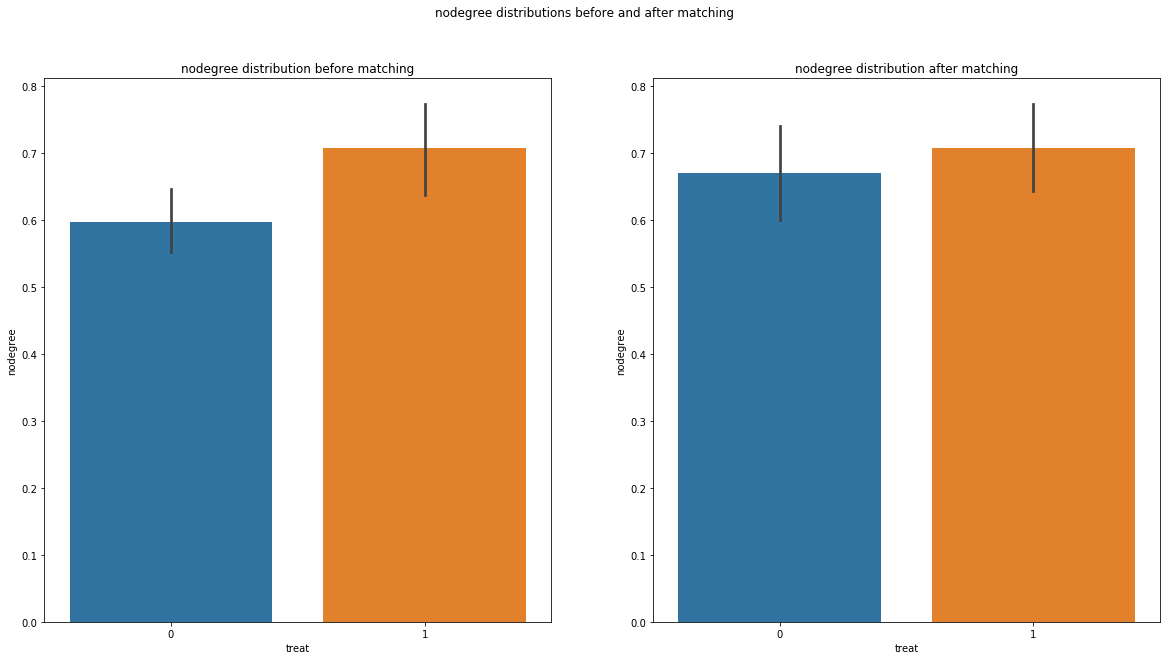

In [139]:
compare_distributions("nodegree")

The nodegree distribution seems to be much better after the matching than before !

married distributions:

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


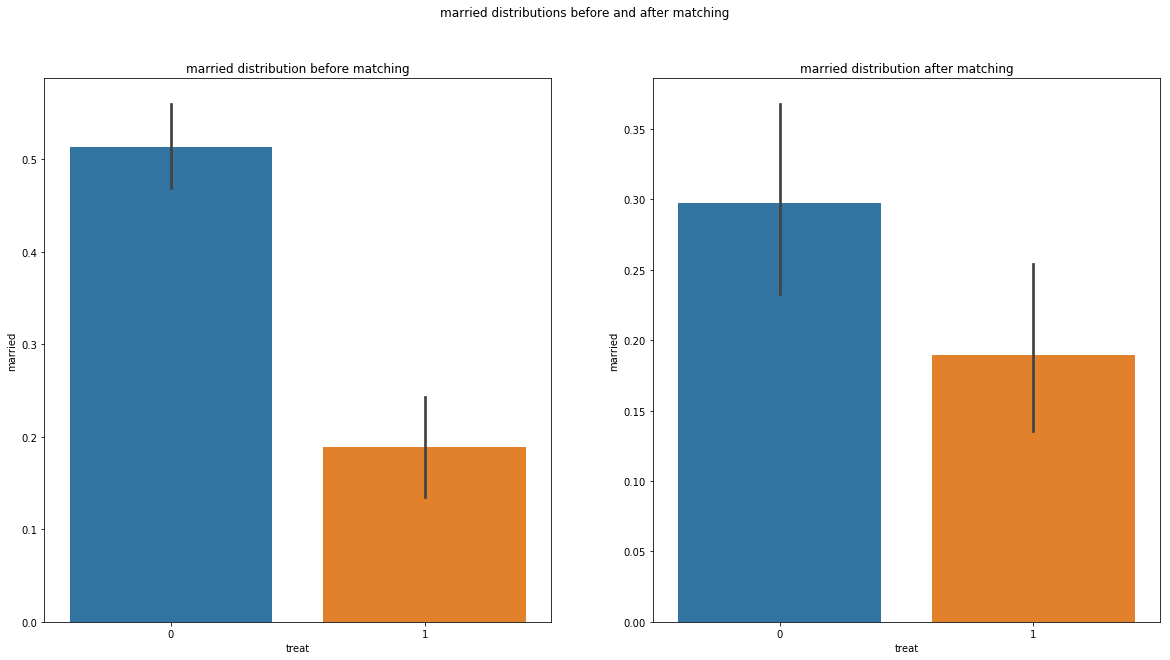

In [123]:
compare_distributions("married")

Better than before ! But still could be much better...

re74 distributions after matching:

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


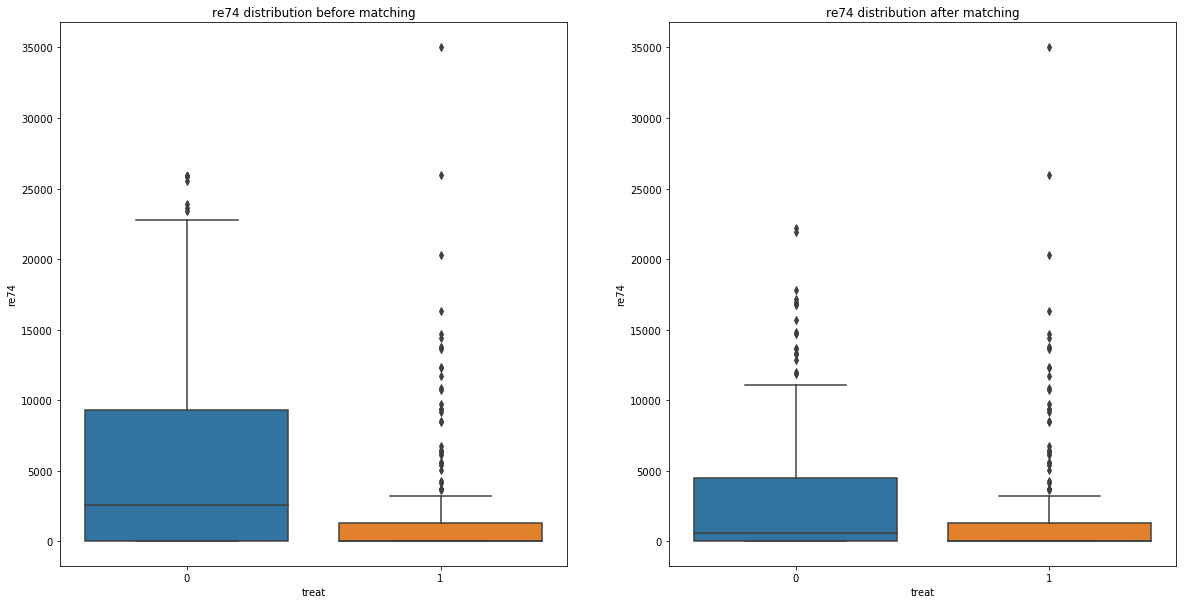

In [97]:
compare_distributions("re74")

The distribution is better in the sense that the treat == 0 distribution got closer to the treat == 1 one. But still, they are different.

re75 distributions after matching:

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


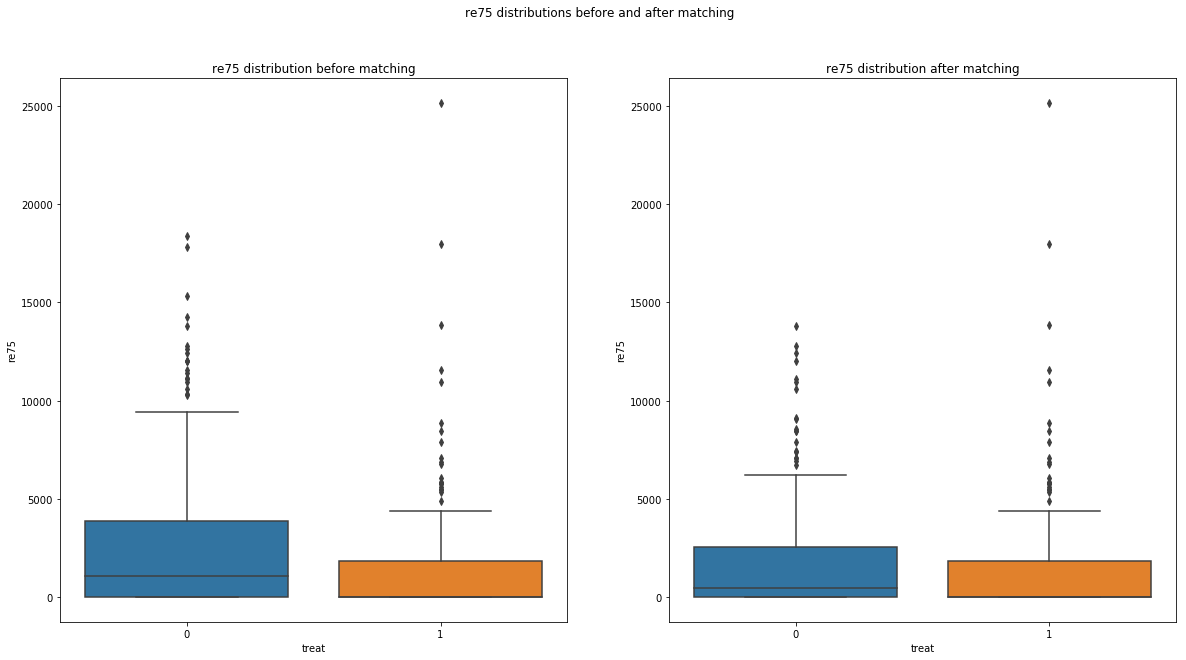

In [124]:
compare_distributions("re75")

We are in better shape here than for re74 (even if the treat == 0 is still more widespread than the treat == 1 distribution)

race distributions after matching:

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


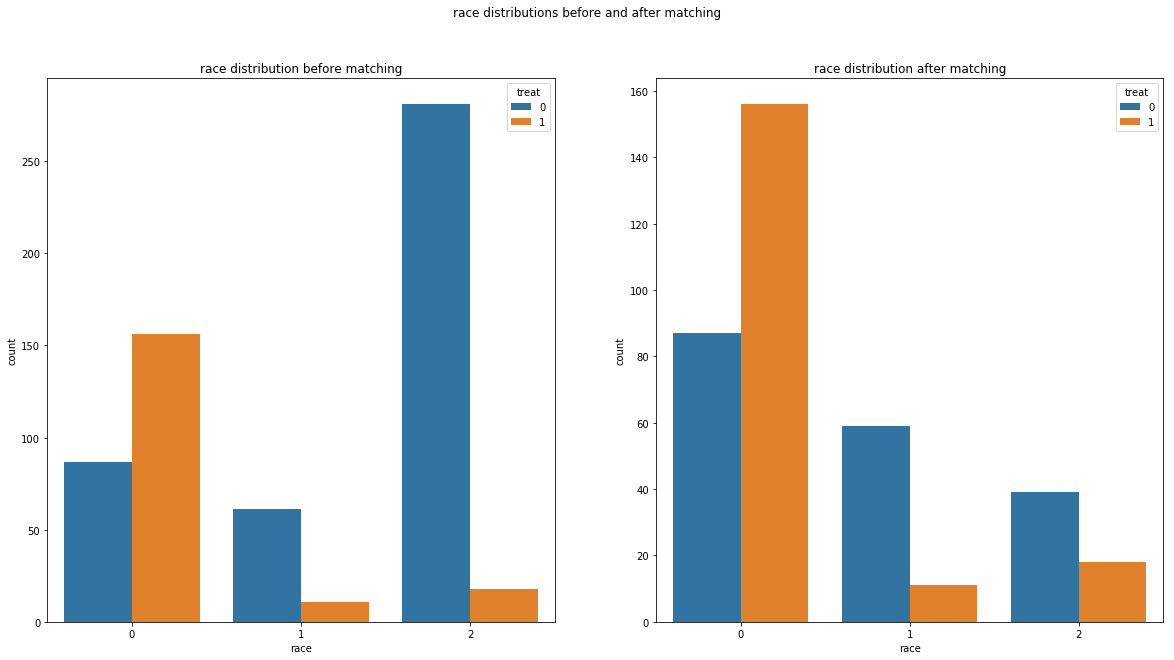

In [125]:
compare_distributions("race")

This one seems to be quite problematic even after the matching ! We don't see much improvement except maybe for the race == 2 (black) case. It could be a good idea to force this feature to be the same in our matching !

## 6

In general we see that features distribution has improved for most features but there are some where we still have problems: the race feature seems to be the most problematic one. Now the solution is to choose a feature and to force the matched items to have the same value for that feature.

In [147]:
def matching_feature_fixed(feature, show_plots=True):
    if feature != None:
        matching_feature_fixed = {k:v for k, v in matching_propensity_max_card.items() if lalonde.loc[k][feature] == lalonde.loc[v][feature]}
    else:
        matching_feature_fixed = matching_propensity_max_card
    group_treat = [a for (a, b) in matching_feature_fixed.items()]
    group_no_treat = [b for (a, b) in matching_feature_fixed.items()]
    feature_fixed_treat = lalonde.loc[group_treat]
    feature_fixed_no_treat = lalonde.loc[group_no_treat]
    if show_plots:
        compare_hist("re78", "re78 distribution after forcing matching on {}".format(feature), no_treat_df=feature_fixed_no_treat, treat_df=feature_fixed_treat)
        compare_distributions("re78", action="forcing " + feature, data1=lalonde_matched, data2=pd.concat([feature_fixed_treat, feature_fixed_no_treat]))
        #sns.boxplot(x="treat", y="re78", data=pd.concat([feature_fixed_treat, feature_fixed_no_treat]))
    return feature_fixed_treat, feature_fixed_no_treat

### Race feature fixed:

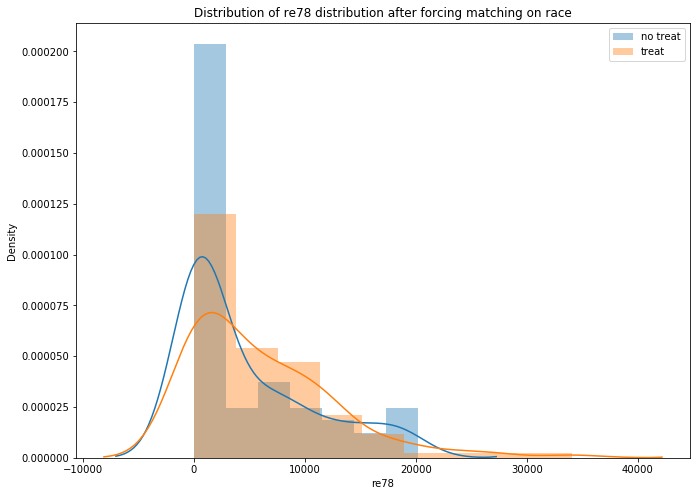

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


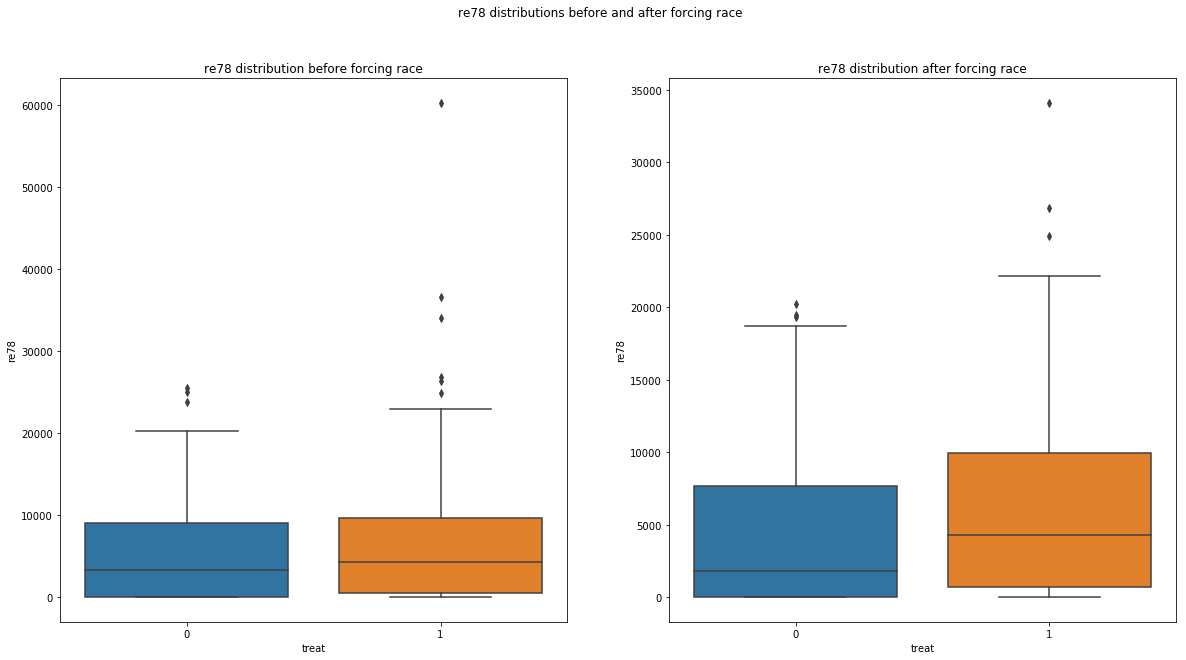

In [148]:
race_fixed_treat, race_fixed_no_treat = matching_feature_fixed("race")

Now the results are much clearer if we force the race to be the same: the treat group is clearly above the no-treat  group !

Just to convince you that the race distribution is the same:

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


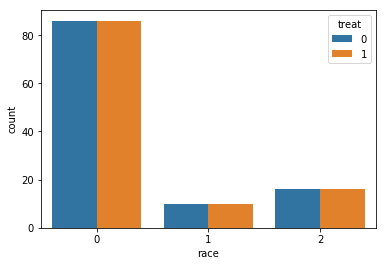

In [149]:
sns.countplot(x="race", hue="treat", data=pd.concat([race_fixed_no_treat, race_fixed_treat]))

### Age feature fixed

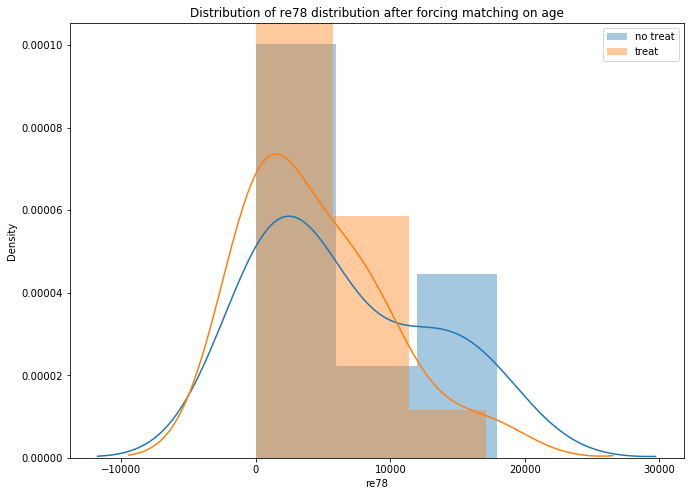

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


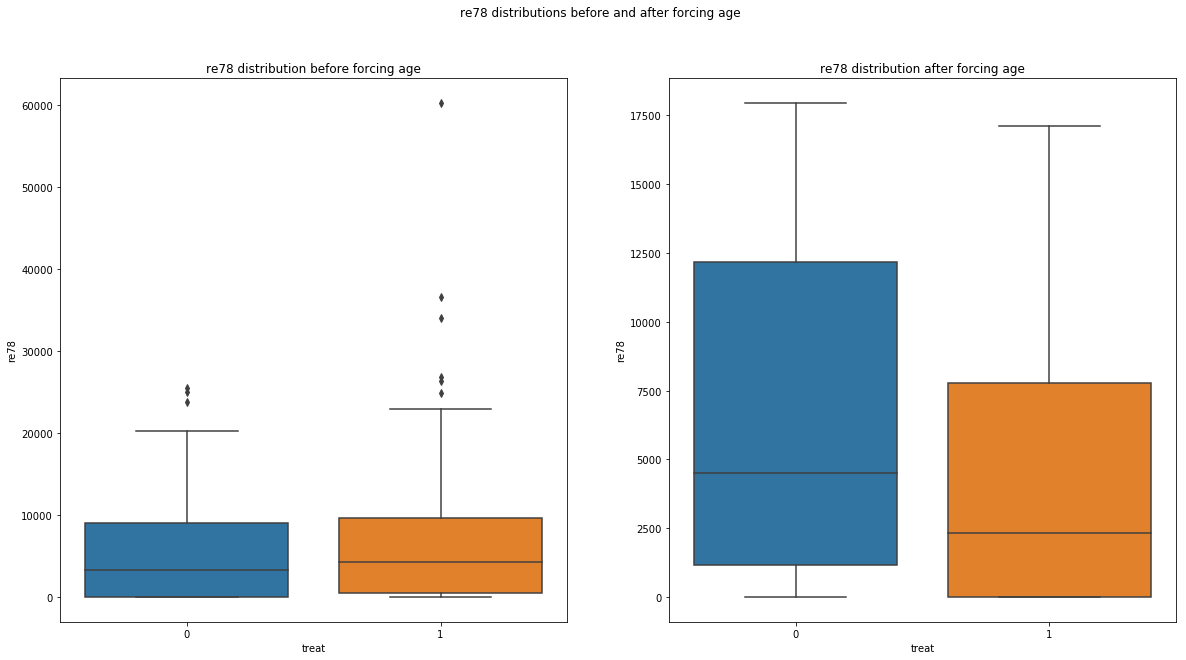

In [150]:
age_fixed_treat, age_fixed_no_treat = matching_feature_fixed("age")

However, if we try to force the age distribution we see that the salary doesn't get better after the treat.

### married

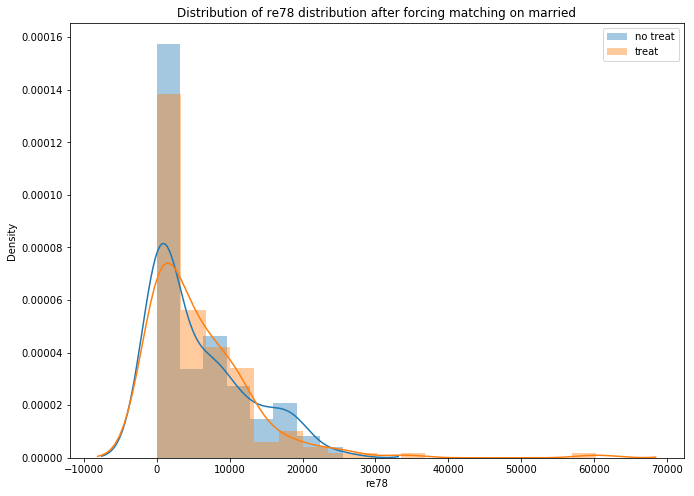

/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


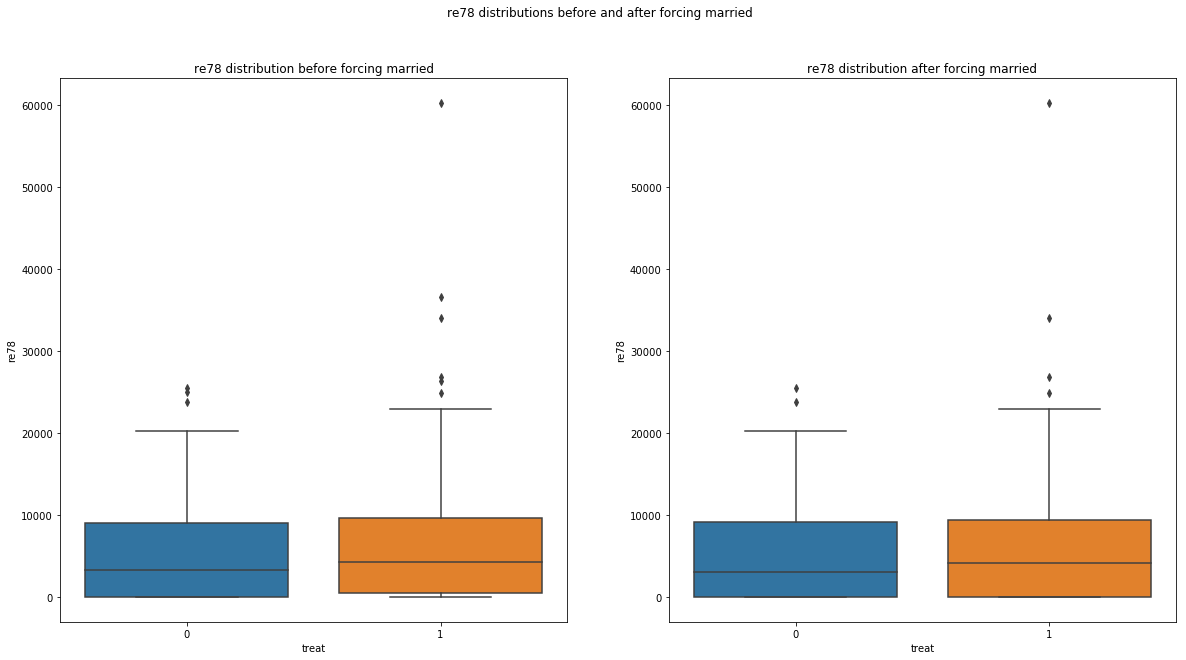

In [151]:
married_fixed_treat, married_fixed_no_treat = matching_feature_fixed("married")

The distribution doesn't really change a lot from the simple matching case.